<a href="https://colab.research.google.com/github/SreeramAdari/Data_Science_Assignmnents/blob/main/Neural_Networking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trial 30 Complete [00h 00m 41s]
val_accuracy: 0.6128125190734863

Best val_accuracy So Far: 0.8828125
Total elapsed time: 00h 07m 57s

Optimal number of layers: 2
Optimal units in first layer: 192
Optimal activation: tanh
Optimal learning rate: 0.01

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2591 - loss: 2.4516 - val_accuracy: 0.5241 - val_loss: 1.5409
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5704 - loss: 1.3947 - val_accuracy: 0.6381 - val_loss: 1.2595
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6327 - loss: 1.2082 - val_accuracy: 0.6591 - val_loss: 1.1310
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6947 - loss: 1.0422 - val_accuracy: 0.7253 - val_loss: 1.0052
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7197 - loss: 0.9474 - val_accuracy: 0.7406 - val_loss: 0.8640
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7569 - loss: 0.7992 - val_accuracy: 0.7791 

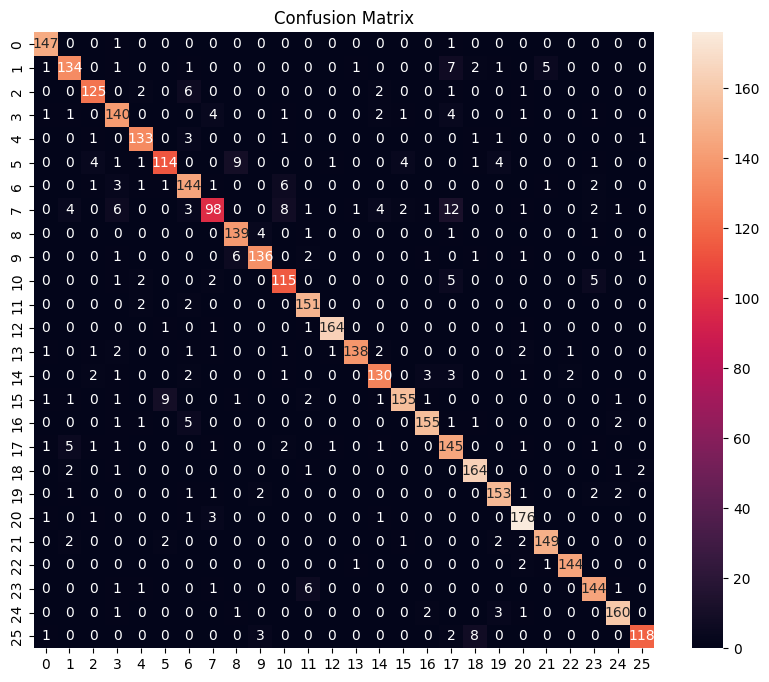

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# 1. Data Loading and Preprocessing
data = pd.read_csv('Alphabets_data.csv')
X = data.drop('letter', axis=1) / 255.0  # Normalize pixel values
y = LabelEncoder().fit_transform(data['letter'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Model Creation Function
def build_model(hp):
    model = Sequential()

    # Tunable number of hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):
        # Tunable number of units
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            activation=hp.Choice('activation', ['relu', 'tanh'])))

    model.add(layers.Dense(len(np.unique(y)), activation='softmax'))

    # Tunable learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

# 3. Implement Hyperparameter Tuning with KerasTuner
!pip install keras-tuner
import keras_tuner as kt

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='tuning',
                     project_name='alphabets')

tuner.search(X_train, y_train, epochs=20, validation_split=0.2)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Optimal number of layers: {best_hps.get('num_layers')}
Optimal units in first layer: {best_hps.get('units_0')}
Optimal activation: {best_hps.get('activation')}
Optimal learning rate: {best_hps.get('learning_rate')}
""")

# 4. Build and train the final model
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

# 5. Evaluation
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")

y_pred = np.argmax(model.predict(X_test), axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()